In [1]:
# Load required libraries
import torch
from torch import optim
import copy
import numpy as np
# -custom-written libraries
import utils
from data.load import get_context_set
from models.classifier import Classifier
from train.train_task_based import train_cl
from eval import evaluate, callbacks as cb
from visual import visual_plt

/home/chenx3n/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Enable plotting in the notebook
%matplotlib inline  

In [3]:
# Is cuda available?
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("CUDA is {}used".format("" if cuda else "not "))

CUDA is not used


## DATA: Prepare the data

In [4]:
# Specify what kind of continual learning experiment we should run
experiment = "5GNIDD"  #--> create context set by splitting up the MNIST dataset
contexts = 4               #--> split the dataset up into how many contexts?
iters = 2000                #--> number of iterations per context
batch = 128                #--> number of samples per iteration (i.e., the mini-batch size)

In [5]:
# More params
acc_log = iters
acc_n = 1024

In [6]:
# Specify according to which scenario the continual learning experiment should be performed?
scenario = "class"

In [7]:
# Where is, or should, the data be stored?
d_dir = './store/datasets'

In [8]:
# Load the context set (both train- and test-data) for the specified continual learning experiment
(train_datasets, test_datasets), config = get_context_set(
    name=experiment, scenario=scenario, contexts=contexts, data_dir=d_dir, verbose=True, exception=True,
)


LabelEncoder mappings:
Benign --> 0
HTTPFlood --> 1
ICMPFlood --> 2
SYNFlood --> 3
SYNScan --> 4
SlowrateDoS --> 5
TCPConnectScan --> 6
UDPFlood --> 7
 --> 5GNIDD: 'train'-dataset consisting of 600452 samples

Scenario: 3


context 0: 
	counts: {0: 179063, 1: 60197, 2: 866, 3: 7291}
	percentages: {0: 0.7237, 1: 0.2433, 2: 0.0035, 3: 0.0295}


context 1: 
	counts: {0: 179064, 1: 60198}
	percentages: {0: 0.7484, 1: 0.2516}


context 2: 
	counts: {0: 179063}
	percentages: {0: 1.0}


context 3: 
	counts: {0: 179063, 2: 866, 3: 7291}
	percentages: {0: 0.9564, 2: 0.0046, 3: 0.0389}


## CLASSIFIER: Specify the classifier network

In [9]:
# Specify the architectural layout of the network to use
fc_lay = 4        #--> number of fully-connected layers
fc_units = 300    #--> number of units in each hidden layer
fc_bn = False     #--> use batch-norm
fc_nl = "relu"    #--> what non-linearity to use?

In [10]:
# Define the model
model = Classifier(
    image_size=config['size'], image_channels=config['channels'], classes=config['output_units'],
    # -conv-layers are not used
    depth=0,
    # -fc-layers
    fc_layers=fc_lay, fc_units=fc_units, fc_bn=fc_bn, fc_nl=fc_nl, excit_buffer=True,
).to(device)

In [11]:
# Indicate to model what scenario it will be trained on and how many classes there are in each context
model.scenario = scenario
model.classes_per_context = config['classes_per_context']

In [12]:
# Print layout of the model to the screen
utils.print_model_info(model)

-------------------------------------------------------
Classifier(
  (convE): ConvLayers(
    (pooling): Identity()
  )
  (flatten): Flatten()
  (fcE): MLP(
    (fcLayer1): fc_layer(
      (linear): LinearExcitability(in_features=81, out_features=300)
      (nl): ReLU()
    )
    (fcLayer2): fc_layer(
      (linear): LinearExcitability(in_features=300, out_features=300)
      (nl): ReLU()
    )
    (fcLayer3): fc_layer(
      (linear): LinearExcitability(in_features=300, out_features=300)
      (nl): ReLU()
    )
  )
  (classifier): fc_layer(
    (linear): LinearExcitability(in_features=300, out_features=8)
  )
)
-------------------------------------------------------
--> this network has 207608 parameters (~0.2 million)
       of which: - learnable: 207608 (~0.2 million)
                 - fixed: 0 (~0.0 million)


#### Create several copies of the network, which each will be trained with a different continual learning method 

In [13]:
model_er = copy.deepcopy(model)

## CL-STRATEGY: Specify the continual learning strategy to use

### Replay

In [14]:
# Experience Replay (ER)
model_er.replay_mode = 'buffer'
model_er.use_memory_buffer = True
model_er.budget_per_class = 100
model_er.sample_selection = 'random'

## CALLBACKS: Specify callback-functions to get insight into training progress

In [15]:
# Callback-function that provides a tqdm progress bar for during training, reporting training loss and accuracy
loss_cbs = [cb._classifier_loss_cb(contexts=contexts, iters_per_context=iters)]

In [16]:
# Prepare for keeping track of performance (on test set) during training, for later plotting
plotting_dict_er = evaluate.initiate_plotting_dict(contexts)

In [17]:
# Callback-function to track test accuracy during training, for later plotting
context_cbs_er = [
    cb._eval_cb(log=iters, test_datasets=test_datasets, plotting_dict=plotting_dict_er, iters_per_context=iters)
]

In [18]:
eval_cbs = [
    cb._eval_cb(log=acc_log, test_datasets=test_datasets, visdom=None, iters_per_context=iters,
                test_size=acc_n)
]

## TRAIN: Train the model on the continual learning experiment

In [19]:
# Settings for the optimizer to use
lr = 0.001           #--> learning rate to use

In [20]:
# For each model, set up the optimizer to use
model_list = [model_er]
for model in model_list:
    model.optim_list = [{'params': filter(lambda p: p.requires_grad, model.parameters()), 'lr': lr}]
    model.optimizer = optim.Adam(model.optim_list, betas=(0.9, 0.999))

#### Train all the models using different continual learning methods

In [21]:
# Experience Replay
train_cl(
    model_er, train_datasets, iters=iters, batch_size=batch, loss_cbs=loss_cbs, context_cbs=context_cbs_er, eval_cbs=eval_cbs, sample_cbs=[None], gen_loss_cbs=[None], generator=None, gen_iters=iters
)

<CLASSIFIER> | Context: 1/4 | training loss: 0.0174 | training accuracy: 1.0 |: 100%|██████████| 2000/2000 [00:58<00:00, 34.46it/s]  
<CLASSIFIER> | Context: 2/4 | training loss: 0.00631 | training accuracy: 1.0 |: 100%|██████████| 2000/2000 [01:03<00:00, 31.46it/s]  
<CLASSIFIER> | Context: 3/4 | training loss: 2.7e-05 | training accuracy: 1.0 |: 100%|██████████| 2000/2000 [01:17<00:00, 25.97it/s]  
<CLASSIFIER> | Context: 4/4 | training loss: 0.000961 | training accuracy: 1.0 |: 100%|██████████| 2000/2000 [01:02<00:00, 31.82it/s] 


## EVALUATION: Plot average accuracy curves throughout training for compared methods

In [22]:
# Collect data for the lines to plot
lines_to_plot = [
    plotting_dict_er["average"]
]

In [23]:
# Specify labels and layout for the plot
line_names = ['ER']
line_colors = ['red']

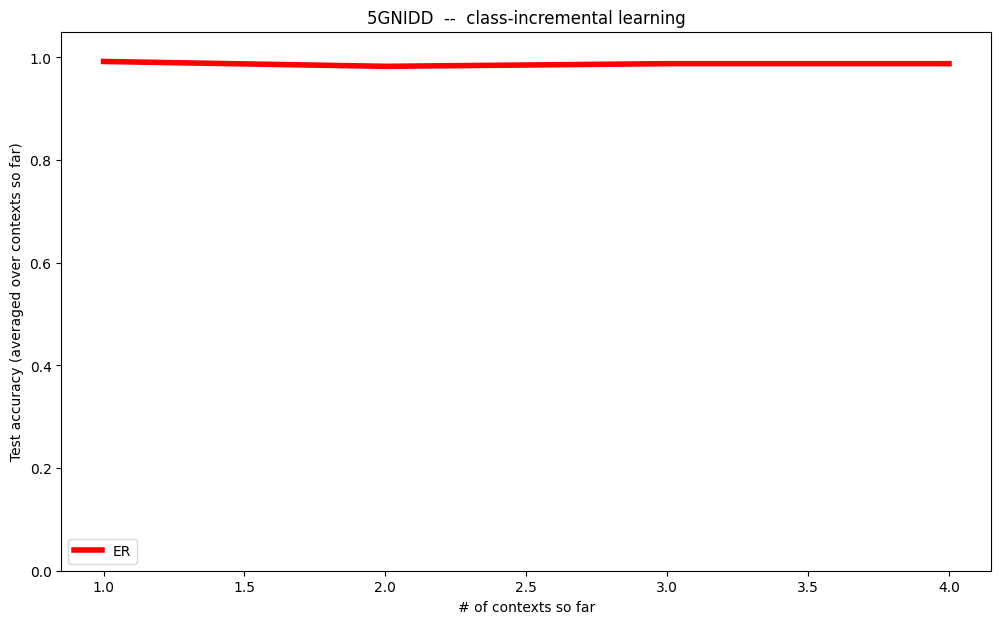

In [24]:
# Create the plot
figure = visual_plt.plot_lines(
    lines_to_plot, x_axes=plotting_dict_er["x_context"], line_names=line_names, colors=line_colors,
    ylabel="Test accuracy (averaged over contexts so far)", ylim=(0,1.05) if scenario=="class" else None,
    xlabel="# of contexts so far", title="{}  --  {}-incremental learning".format(experiment, scenario)
)